# MIS 583 Assignment #3-2 Self Supervised Learning

Before we start, please put your name and ID in following format: <br>
NAME, ?000000000   e.g. 陳耀融, M094020055

**Your Answer:**   
Hi I'm 邱承漢, M104020029

**Outline:**
- Dataset of Semi-Supervised Learning
- Train with labeled data
    - Loading Data
    - Model and Optimizer
    - Train and Test Function
    - Load from checkpoint
    - Or train a new one
- Start Self-Learning
    - Semi dataset
    - Optimizer and loss
    - Inspect the confidence
    - Training process
    - Final Finetune Stage
    - Predict

First part is from assignment #3, we train a whole new model. Or you can use the same architecture and weights from checkpoint file.

Seconde part is Self Supervised Learning for semi-supervised learning problem.

## Kaggle Competition

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/d288f1f130294567b37614e649f9536d) to join the competition.

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

I use `python 3.8.11`, `torch==1.8.2` and `torchvision==0.9.2`

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.7.12 (default, Sep 10 2021, 00:21:48) 
torch 1.10.0+cu111
torchvision 0.11.1+cu111


## How to Get Data

Please open the file `assignment_3-2_data_flowers_2021.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/1UEScdRXSnT1XTInYMlWcvNdgNuBs4hOf/view)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `assignment_3-2_data_flowers_2021.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1UEScdRXSnT1XTInYMlWcvNdgNuBs4hOf/view)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

1. Executing the below code which will provide you with an authentication link
2. Open the link
3. Choose the Google account whose Drive you want to mount
4. Allow Google Drive Stream access to your Google Account
5. Copy the code displayed, paste it in the text box as shown below, and press Enter
![](https://i1.wp.com/neptune.ai/wp-content/uploads/colab-code-copy.png?resize=512%2C102&ssl=1)

Finish!

---

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq ./drive/MyDrive/Colab\ Notebooks/NSYSU\ IM/深度學習/Assignment3-2/assignment_3-2_data_flowers_2021.zip

## Dataset of Semi-Supervised Learning

We split data into 4 subsets:
- 30% labeled for training
- 10% for validation
- 10% for testing set(uplaod to kaggle)
- **50% unlabeled for training (provided in this assignment)**

The whole dataset is from https://www.kaggle.com/c/flower-classification-2019/overview  
There are 4316 images total.

First, **we split 431(10%) images out as testing set**.
During assignment #3 and assignment #4, students should **upload the predicted labels by this testing set**.  

Next, **430(10%) images is drawn out as validation set**. Used to evalute the performance of the model.  

Last, **1295(30%) images is labeled training set. 2160(50%) images is unlabeled training set.**

## Train with labeled data

You can train a whole new model.

Or load the weights from assignment #3 using checkpoint file.

### Loading Data

Same as assignment #3

In [ ]:
data_folder = 'assignment_3-2_data_flowers_2021'

In [ ]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class FlowerData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.transform = transform
        
        with open(f'{data_folder}/{csv_file}', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(f"{data_folder}/{row['file_path']}")
                if mode != 'test':
                    self.labels.append(row['label'])

    def __getitem__(self, index):
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        label = torch.tensor(int(self.labels[index]))

        return data, label

    def __len__(self):
        return len(self.data_list)

In [ ]:
from torchvision import transforms

transforms_train = transforms.Compose([
  transforms.RandomResizedCrop(size=(256,256), scale=(0.8,1.0)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ColorJitter(),
  transforms.CenterCrop(size=(224,224)),
  transforms.ToTensor(),
  #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])  

transforms_test = transforms_test = transforms.Compose([
  transforms.Resize((256,256)),
  transforms.CenterCrop((224,224)),
  transforms.ToTensor(),
  #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset_train = FlowerData('train.csv', mode='train', transform=transforms_train)
dataset_val = FlowerData('val.csv', mode='val', transform=transforms_test)
dataset_test = FlowerData('test.csv', mode='test', transform=transforms_test)

In [ ]:
print("The first image's shape in dataset_train :", dataset_train[0][0].size())
print("There are", len(dataset_train), "images in dataset_train.")
print("There are", len(dataset_test), "images in dataset_test.")
print("There are", len(dataset_val), "images in dataset_val.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 1295 images in dataset_train.
There are 431 images in dataset_test.
There are 430 images in dataset_val.


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 2
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Model and Optimizer

Define new model and re-train it.  
Or use old architecture and load the weights from checkpoint file.

In [ ]:
device = torch.device('cuda:0')

In [ ]:
from torch import nn
import torch.nn.functional as F

# 定義 Residual Block
class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResBlock, self).__init__()
        # Conv -> Relu -> Conv
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            #shortcut，兩層卷積完的output_channel數要等於原本的input_channel數才能相加
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        #將兩層卷積後的輸出與處理過的x相加，實現ResNet的基本結構
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out
class ResNet(nn.Module):
    def __init__(self, ResBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            # in = (256,256) -> out = (256,256)
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(ResBlock, 512, 2, stride=2)        
        self.fc = nn.Linear(25088, num_classes)
    # 堆疊Residual Block    
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # ResNet18
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



In [ ]:
model = ResNet(ResBlock)
model = model.to(device)
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Train and Test Function

In [ ]:
def train(input_data, model, criterion, optimizer):
    model.train()

    loss_list = []
    total_count = 0
    acc_count = 0
    for i, (images, labels) in enumerate(input_data, 0):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        pred = torch.argmax(outputs, dim=1)
        acc_count += (pred == labels).sum().item()
        total_count += images.shape[0]
        loss_list.append(loss.item())

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

In [ ]:
@torch.no_grad()
def val(input_data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(input_data, 0):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            pred = torch.argmax(outputs, dim=1)
            acc_count += (pred == labels).sum().item()
            total_count += images.shape[0]
            loss_list.append(loss.item())

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

If you wanna self-training, just above lines need to be executed.

### Load from checkpoint

In [ ]:
import os
os.makedirs('assign3-2_ckpts', exist_ok=True)
ckpt_f = None

if ckpt_f:
    model.load_state_dict(torch.load(ckpt_f))
    t_val_acc, t_val_loss = val(train_loader, model, criterion)
    print('train val acc\t', t_val_acc, 'loss', t_val_loss)
    val_acc, val_loss = val(val_loader, model, criterion)
    print('val acc\t\t', val_acc, 'loss', val_loss)

### Or train a new one

In [ ]:
class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []
    
    def update(self, train_acc, train_loss, val_acc, val_loss):
        self.train_acc_list.append(train_acc)
        self.train_loss_list.append(train_loss)
        self.val_acc_list.append(val_acc)
        self.val_loss_list.append(val_loss)
    
    def plot(self):
        x = range(len(self.train_loss_list))
        
        plt.figure(figsize=(12, 4))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train', 'test'])
        plt.title('Loss')
        plt.show()
        plt.figure(figsize=(12, 4))
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train', 'test'])
        plt.title('Acc')
        plt.show()

==================== Epoch 1 ====================
Train Acc: 0.304247 Train Loss: 3.278625
  Val Acc: 0.351163   Val Loss: 4.861528
==================== Epoch 2 ====================
Train Acc: 0.428571 Train Loss: 2.022964
  Val Acc: 0.423256   Val Loss: 3.608757
==================== Epoch 3 ====================
Train Acc: 0.454054 Train Loss: 1.666675
  Val Acc: 0.469767   Val Loss: 3.927890
==================== Epoch 4 ====================
Train Acc: 0.520463 Train Loss: 1.405957
  Val Acc: 0.511628   Val Loss: 1.630238
==================== Epoch 5 ====================
Train Acc: 0.529730 Train Loss: 1.222481
  Val Acc: 0.460465   Val Loss: 1.379140
==================== Epoch 6 ====================
Train Acc: 0.542085 Train Loss: 1.121088
  Val Acc: 0.460465   Val Loss: 1.331359
==================== Epoch 7 ====================
Train Acc: 0.556757 Train Loss: 1.111635
  Val Acc: 0.516279   Val Loss: 1.305799
==================== Epoch 8 ====================
Train Acc: 0.566023 Train 

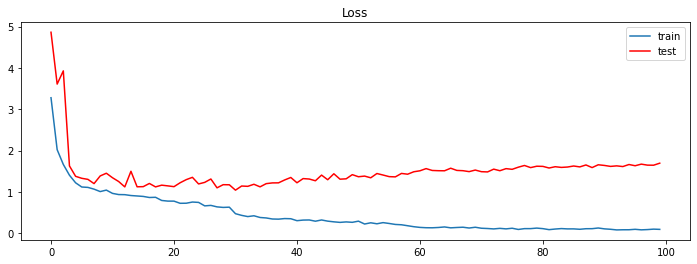

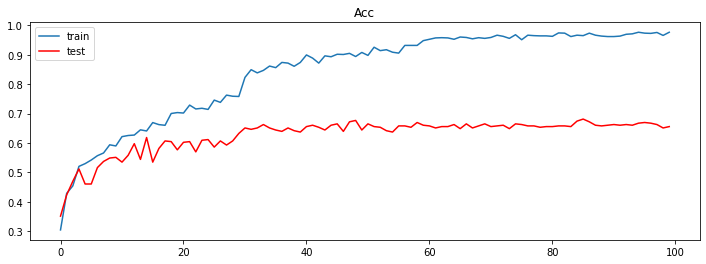

CPU times: user 2h 56min 4s, sys: 1min 2s, total: 2h 57min 6s
Wall time: 2h 58min 52s


In [ ]:
%%time

if not ckpt_f:
    from torch.optim.lr_scheduler import StepLR

    max_epochs = 100
    log_interval = 1
    m = Meter()

    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    for epoch in range(1, max_epochs + 1):
        train_acc, train_loss = train(train_loader, model, criterion, optimizer)
        val_acc, val_loss = val(val_loader, model, criterion)
        scheduler.step()

        m.update(train_acc, train_loss, val_acc, val_loss)

        # if get higher acc, save checkpoint
        if epoch % log_interval == 0:
            print('=' * 20, 'Epoch', epoch, '=' * 20)
            print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
            print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))
    torch.save(model.state_dict(), 'assign3-2_ckpts/resnext_e{:03}_vacc_{:.02}_vloss_{:.02}.pt'.format(epoch, val_acc, val_loss))
    
    import matplotlib.pyplot as plt
    m.plot()

## Start self-learning !

Let's borrow some informations from unlabeled data.

Build a dataset focus on the labeled data and unlabeled data.

Note that we add a method named combine.

It will add unlabeld x + predicted y into training set.

### Semi Dataset

In [ ]:
class SemiFlowerData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode  # 'train', 'train_ul'
        self.data_list = []
        self.labels = []
        self.transform = transform

        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(data_folder + '/' + row['file_path'])
                if mode != 'train_ul':
                    self.labels.append(row['label'])

    def __getitem__(self, index):
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)

        if self.mode == 'train_ul':
            return data
        else:
            label = torch.tensor(int(self.labels[index]))
            return data, label
    
    def combine(self, dataset, idxs, labels):
        self.data_list += [dataset.data_list[i] for i in idxs]
        self.labels += [labels[i] for i in idxs]
        # remove second dataset using idxs set 
        dataset.data_list = [d for i, d in enumerate(dataset.data_list) if i not in idxs]
        dataset.labels = [l for i, l in enumerate(dataset.labels) if i not in idxs]

    def __len__(self):
        return len(self.data_list)

In [ ]:
from torchvision import transforms

transforms_train = transforms.Compose([
  transforms.RandomResizedCrop(size=(256,256), scale=(0.8,1.0)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ColorJitter(),
  transforms.CenterCrop(size=(224,224)),
  transforms.ToTensor(),
  #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])  

transforms_test = transforms_test = transforms.Compose([
  transforms.Resize((256,256)),
  transforms.CenterCrop((224,224)),
  transforms.ToTensor(),
  #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Use new dataset to init train and train_ul

In [ ]:
dataset_train = SemiFlowerData(f'{data_folder}/train.csv', mode='train', transform=transforms_train)
dataset_train_ul = SemiFlowerData(f'{data_folder}/train_ul.csv', mode='train_ul', transform=transforms_test)

In [ ]:
print("The first image's shape in dataset_train :", dataset_train[0][0].size())
print("There are", len(dataset_train), "images in dataset_train.")
print("There are", len(dataset_train_ul), "images in dataset_train_ul.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 1295 images in dataset_train.
There are 2160 images in dataset_train_ul.


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 2
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
train_ul_loader = DataLoader(dataset_train_ul, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Optimizer and loss

Same as Assignemt #3

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Inspect the confidence

Self-traingin can deal with semi-supervised problem.  

In self-training, we do these steps:
- generate predicted labeled from unlabeled set.
- Some of them have higher confidences.
- Pick them (unlabeled x + predicted y) up as new data point and add into training set.
- Re-train.
- **keep above procedure until end statement(no unlabeled data or reach max number of iterations)**

First, let's take a look to the distribution of confidences.

In [ ]:
train_ul_confs = []
train_ul_labels = []
model.eval()
with torch.no_grad():
    for imgs in train_ul_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        train_ul_confs += torch.softmax(out, dim=1).amax(dim=1).detach().tolist()
        train_ul_labels += out.argmax(dim=1).detach().tolist()

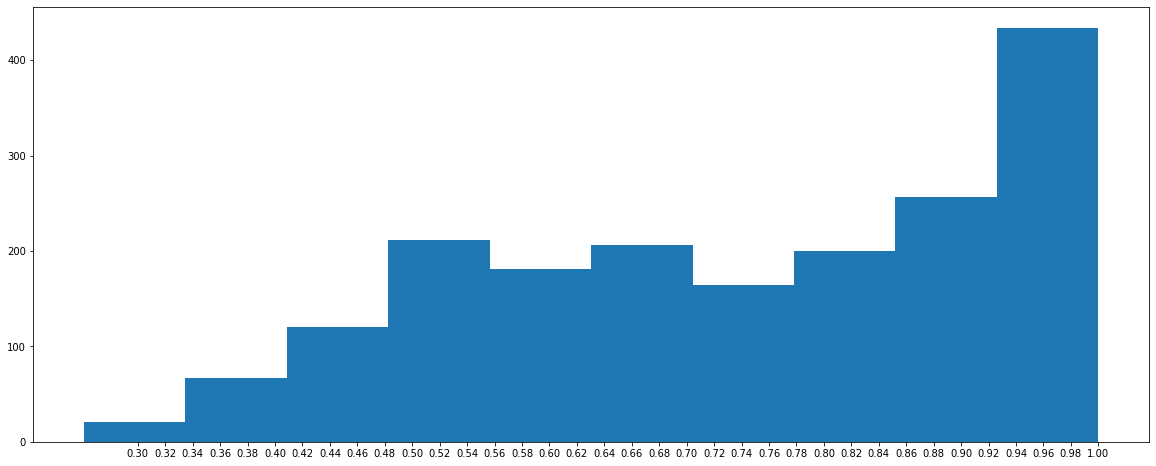

In [ ]:
# plot them
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.hist(train_ul_confs)
plt.xticks(np.arange(round(min(train_ul_confs), 1), 1.01, 0.02))
plt.show()

So, you should choose a threshold based on the distribtion of confidences.

### Training process of semi self learning

We should follow steps below.

1. Calculate confidents using unlabeled dataset
2. Sample some of thme out
3. Add to training set
4. finetune few epochs
5. repeat

In [ ]:
# ========= Hyper-parameters =========
finetune_epochs = 2 # epochs of finetune in each iteration
finetune_lr = 1e-3

conf_threshold = 0.99 # conf of images >= threshold as cannidate
max_imgs = 300 # sample max_imgs out if candidate images is >= max_imgs

iters = 0 # start index
max_iters = 3 # max

In [ ]:
# Use the confidence threshold to predict

dataset_train_ul = SemiFlowerData(f'{data_folder}/train_ul.csv', mode='train_ul', transform=transforms_test)
m = Meter()

# ========= Start Training =========
# end if no data in dataset or reach max_iters
while len(dataset_train_ul) > 0:
    if iters >= max_iters:
        break
    iters += 1

    # ---------- Optimizer and DataLoader ----------
    # ##################### Define Optimizer #####################
    optimizer = torch.optim.Adam(model.parameters(), lr=finetune_lr)
    # ############################################################

    print('=' * 20, f'finetune stage {iters} with {len(dataset_train_ul)} iamges', '=' * 20)
    train_ul_loader = DataLoader(dataset_train_ul, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    
    # ---------- Calculate conf and labels using unlabeled dataset ----------
    train_ul_labels = []
    train_ul_confs = []
    model.eval()
    with torch.no_grad():
        for imgs in train_ul_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            train_ul_confs += torch.softmax(out, dim=1).max(dim=1)[0].detach().cpu().tolist()
            train_ul_labels += out.argmax(dim=1).detach().cpu().tolist()
    train_ul_confs = torch.tensor(train_ul_confs)
    
    # ---------- Sample some indexs out ----------
    all_idxs = torch.arange(len(dataset_train_ul))
    add_idxs = all_idxs[train_ul_confs >= conf_threshold] # use threshold
    
    # ##################### How to Draw max_imgs images out #####################
    print('all_idxs',all_idxs)
    print('add_idxs',add_idxs)
    print('train_ul_confs',train_ul_confs)
    if len(add_idxs) > max_imgs:
        #add_idxs = add_idxs[:max_imgs] # 直接抓前300個(random)
        #print(add_idxs.values,type(add_idxs))
        sorted_confs_values, sorted_confs_indices = train_ul_confs.sort(descending = True)
        print(sorted_confs_values)
        print(sorted_confs_indices)
        add_idxs = all_idxs[sorted_confs_indices]
        print('add_idxs', add_idxs)
        # there are many images >= conf_threshold
        # design a strategy to select max_imgs out
        # e.g. random, the highest conf, balance of labels...

        # in the final, you should have a add_idxs list its length is max_imgs

        add_idxs = add_idxs.sort().values # torch sort

    # ###########################################################################

    print('Add {} images conf >= {} into training set'.format(len(add_idxs), conf_threshold))
    
    # ---------- add to labeled training dataset ----------
    # ##################### Add to training dataset #####################
    dataset_train.combine(dataset_train_ul, add_idxs, train_ul_labels)
    # ###################################################################
    train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    
    # ---------- finetune ----------
    for e in range(1, finetune_epochs + 1):
        train_acc, train_loss = train(train_loader, model, criterion, optimizer)
        val_acc, val_loss = val(val_loader, model, criterion)
        m.update(train_acc, train_loss, val_acc, val_loss)
        
        print('-' * 20, 'Epoch', e, '-' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))
    m.plot()

==================== finetune stage 1 with 2160 iamges ====================


In [ ]:
t_val_acc, t_val_loss = val(train_loader, model, criterion)
print('train val acc\t', t_val_acc, 'loss', t_val_loss)
val_acc, val_loss = val(val_loader, model, criterion)
print('val acc\t\t', val_acc, 'loss', val_loss)

train val acc	 0.8322368421052632 loss 0.4174977820693401
val acc		 0.7 loss 0.8395807027816773


### Final Finetune Stage

Use smaller(finetune_lr * 0.1 are there) to do final tinetune stage.  
I use the best_acc to record best_state to prevent overfitting.

-------------------- Epoch 1 --------------------
Train Acc: 0.887610 Train Loss: 0.325592
  Val Acc: 0.774419   Val Loss: 0.719835
-------------------- Epoch 2 --------------------
Train Acc: 0.905154 Train Loss: 0.286203
  Val Acc: 0.781395   Val Loss: 0.740542
-------------------- Epoch 3 --------------------
Train Acc: 0.910088 Train Loss: 0.266561
  Val Acc: 0.793023   Val Loss: 0.715389


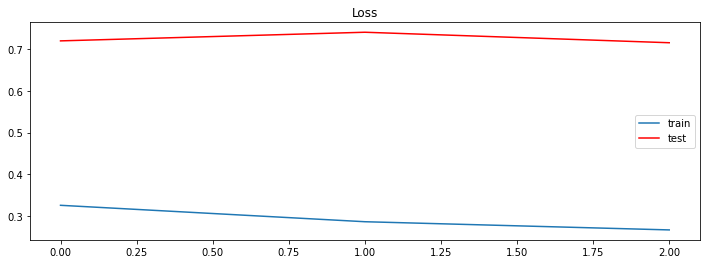

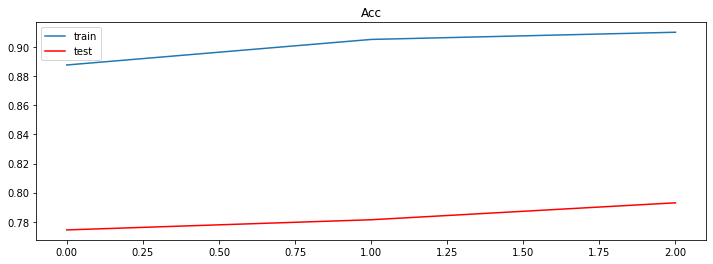

In [ ]:
# ##################### Optimizer #####################
optimizer = torch.optim.Adam(model.parameters(), lr=finetune_lr*0.1)
# #####################################################

best_acc = 0

m = Meter()

for e in range(1, 4):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)
    # little early-stop
    if val_acc > best_acc:
        bast_acc = val_acc
        best_state = model.state_dict()
    m.update(train_acc, train_loss, val_acc, val_loss)

    print('-' * 20, 'Epoch', e, '-' * 20)
    print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
    print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))
m.plot()

In [ ]:
t_val_acc, t_val_loss = val(train_loader, model, criterion)
print('train val acc\t', t_val_acc, 'loss', t_val_loss)
val_acc, val_loss = val(val_loader, model, criterion)
print('val acc\t\t', val_acc, 'loss', val_loss)

train val acc	 0.930921052631579 loss 0.21778210487804914
val acc		 0.7930232558139535 loss 0.7153890669345856


In [ ]:
# save your checkpoint
torch.save(best_state, 'assign3-2_ckpts/SSL_best.pt')
torch.save(model.state_dict(), 'assign3-2_ckpts/SSL_final_finetune.pt')

### Predict

In [ ]:
# load checkpoint
#ckpt_f = 'assign3-2_ckpts/SSL_best.pt'
ckpt_f = '/content/drive/MyDrive/Colab Notebooks/NSYSU IM/深度學習/Assignment3-2/assign3-2_ckpts/vgg_vacc_80.pt'
model.load_state_dict(torch.load(ckpt_f, map_location=device))

NameError: ignored

In [ ]:
t_val_acc, t_val_loss = val(train_loader, model, criterion)
print('train val acc\t', t_val_acc, 'loss', t_val_loss)
val_acc, val_loss = val(val_loader, model, criterion)
print('val acc\t\t', val_acc, 'loss', val_loss)

train val acc	 0.930921052631579 loss 0.22034318013149395
val acc		 0.7930232558139535 loss 0.7153890669345856


In [ ]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for data in input_data:
            images = data.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [ ]:
idx = 0
output_csv = predict(test_loader, model)
with open('pre_ssl_result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'label'])
    writer.writeheader()
    for result in output_csv:
        file_path = dataset_test.data_list[idx].replace(data_folder + '/', '')
        writer.writerow({'file_path':file_path, 'label':result})
        idx += 1